In [235]:
import pandas as pd
import numpy as np

In [236]:
order = 5
states = 4


transitionProbabilities = np.ndarray((states, states))
transitionProbabilities[:] = 0

transitionCounts = np.ndarray((states, states))
transitionCounts[:] = 0

transitionStateCounts = np.zeros(states)



In [237]:
def jsonToDataFrame(stockData):
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    dates = []

    for key in stockData:
        (open_, high, low, close, volume) = stockData[key]
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        dates.append(key)

    data = {'Date':dates, 'Open':opens, 'High':highs, 'Low':lows, 'Close':closes, 'Volume': volumes}

    return pd.DataFrame(data=data)

In [238]:



def convertArrayToTimeSeries(array, duration):
    length = len(array) - duration
    if(length <= 0):
        return np.ndarray((0,duration))

    subTimeSeries = np.ndarray((length, duration))
    for i in range(length):
        subTimeSeries[i] = array[i:i+duration]
    return subTimeSeries

def normalizeTimeSeries(timeSeries):
    avg = np.mean(timeSeries, axis=1)
    var = np.var(timeSeries, axis=1)
    

    timeSeriesNorm = np.ndarray(timeSeries.shape)
    for i in range(len(timeSeries)):
        if(var[i] == 0):
            timeSeriesNorm[i] = np.zeros(timeSeries[i].shape)
        else:
            timeSeriesNorm[i] = (timeSeries[i] - avg[i])/var[i]
    return timeSeriesNorm




In [239]:
from convertStockToJson import getJsonDataFromFile

def loadTimeSeriesNormalized(name):
    stockData = getJsonDataFromFile(name)
    stockDatadf = jsonToDataFrame(stockData) 
    subTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], order)
    return normalizeTimeSeries(subTimeSeries)


In [240]:
subTimeSeriesNorm = loadTimeSeriesNormalized('VAS')

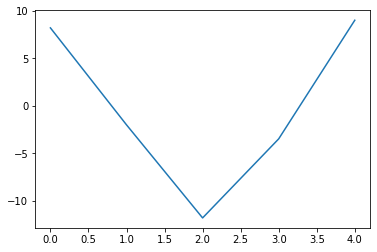

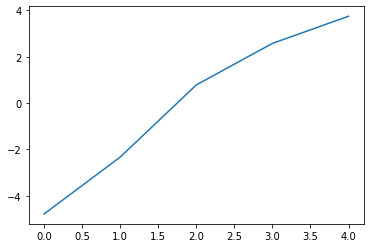

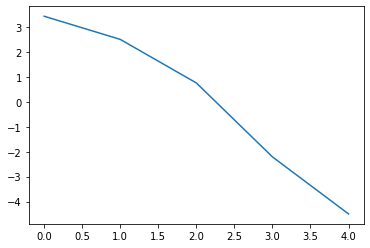

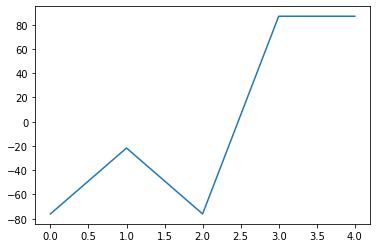

In [241]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt




kmeans = KMeans(n_clusters=states, random_state=0).fit(subTimeSeriesNorm)

for cluster in kmeans.cluster_centers_:
   
    plt.plot(cluster)
    plt.show()






In [242]:
subTimeSeriesClassified = kmeans.predict(subTimeSeriesNorm)

In [243]:

def trainMarkokChain(subSeriesClassifified):
    for i in range(len(subSeriesClassifified)-1):
        currentState = subSeriesClassifified[i]
        nextState = subSeriesClassifified[i+1]
        
        transitionCounts[currentState, nextState] += 1
        transitionStateCounts[currentState] += 1


trainMarkokChain(subTimeSeriesClassified)


print(transitionCounts)
print(transitionStateCounts)

[[  6.  47.  13.   0.]
 [  9. 363.  85.   1.]
 [ 51.  48. 382.   0.]
 [  0.   0.   1.   0.]]
[ 66. 458. 481.   1.]


In [244]:
def updateProbabilities():
    for i in range(transitionProbabilities.shape[0]):
        if(transitionStateCounts[i] != 0):
            for j in range(transitionProbabilities.shape[1]):
                transitionProbabilities[i, j] = transitionCounts[i, j]/transitionStateCounts[i]

updateProbabilities()
print(transitionProbabilities)

[[0.09090909 0.71212121 0.1969697  0.        ]
 [0.01965066 0.79257642 0.18558952 0.00218341]
 [0.10602911 0.0997921  0.79417879 0.        ]
 [0.         0.         1.         0.        ]]


In [245]:
def loadTimeSeriesClassified(name):
    normalized = loadTimeSeriesNormalized(name)
    if(normalized.shape[0] > 0):
        return (kmeans.predict(normalized), True)
    else:
        return (None, False)

In [246]:
def testMarkovChain(subSeriesClassifified):
    numCorrect = 0
    length = len(subSeriesClassifified)-1
    for i in range(length):
        currentState = subSeriesClassifified[i]
        nextStateCorrect = subSeriesClassifified[i+1]
        nextStatePredict = np.argmax(transitionStateCounts[currentState])
        if(nextStatePredict == nextStateCorrect):
            numCorrect += 1
    if(length > 0):
        return numCorrect/length
    else:
        return None

In [247]:
from filesInPath import filesInPath

filenames = filesInPath('data')
import random

# random.shuffle(filenames)
# filenames = filenames[:40]
filenames = ['VAS', 'IOO', 'XRO']

for (fileName,i) in zip(filenames, range(len(filenames))):
    #fileName = fileName[:-5]
 
    (timeSeriesClassified, success) = loadTimeSeriesClassified(fileName)  
    if(success):  
        percetage = testMarkovChain(timeSeriesClassified)  
        if(percetage != None):
            print(fileName + ",  " + str(percetage * 100 ) + "%")


VAS,  0.9930486593843099%
IOO,  0.9930486593843099%
XRO,  6.560636182902585%
